<a href="https://colab.research.google.com/github/rachelyayra/start-and-stop/blob/main/Stopnstart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Voice Command Detection using MFCC and SVM
  

*   This file contains code for preprocessing audio data using Mel-Frequency Cepstral Coefficients (MFCC) and detecting voice commands for "start" and "stop" using a Support Vector Machine (SVM) classifier.
*   The technique has an F1 Score of **0.8** and an accuracy of **0.78**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Data Processing and Feature Extraction

Import relevant libraries

In [2]:
import warnings

# Suppress librosa FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
pip install ffmpeg

In [4]:
pip install --upgrade librosa

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from glob import glob
import librosa
import librosa.display
import IPython.display as ipd
import ffmpeg
from itertools import cycle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score

sns.set_theme(style="white", palette=None)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

In [6]:
start_audio = glob('/content/drive/My Drive/sounds/start/*.m4a')
stop_audio = glob('/content/drive/My Drive/sounds/stop/*.m4a')

In [7]:
print(stop_audio)

['/content/drive/My Drive/sounds/stop/stop_1.m4a', '/content/drive/My Drive/sounds/stop/stop_2.m4a', '/content/drive/My Drive/sounds/stop/stop_3.m4a', '/content/drive/My Drive/sounds/stop/stop_4.m4a', '/content/drive/My Drive/sounds/stop/stop_5.m4a', '/content/drive/My Drive/sounds/stop/stop_6.m4a', '/content/drive/My Drive/sounds/stop/stop_7.m4a', '/content/drive/My Drive/sounds/stop/stop_8.m4a', '/content/drive/My Drive/sounds/stop/stop_9.m4a', '/content/drive/My Drive/sounds/stop/stop_10.m4a', '/content/drive/My Drive/sounds/stop/stop_11.m4a', '/content/drive/My Drive/sounds/stop/stop_12.m4a', '/content/drive/My Drive/sounds/stop/stop_13.m4a', '/content/drive/My Drive/sounds/stop/stop_14.m4a']


In [8]:
#play audio file
ipd.Audio(start_audio[0])

In [9]:
ipd.Audio(stop_audio[0])

In [10]:
y , sr = librosa.load(start_audio[0])
print(f'y: {y[:10]}')
print(f'shape y: {y.shape}')
print(f'sr: {sr}')
x , sr = librosa.load(stop_audio[0])
print(f'x: {x[:10]}')
print(f'shape x: {x.shape}')
print(f'sr: {sr}')

y: [ 2.8421709e-12  1.4779289e-12 -1.1368684e-12 -2.5011104e-12
 -1.4210855e-12 -2.2737368e-13  1.2505552e-12 -1.1368684e-13
  1.1368684e-12  5.6843419e-13]
shape y: (29184,)
sr: 22050
x: [-1.8189894e-12  1.8189894e-12 -3.1832315e-12  1.7053026e-12
 -1.4779289e-12  1.8189894e-12 -5.1159077e-13 -1.2505552e-12
 -3.9790393e-13  6.3664629e-12]
shape x: (32768,)
sr: 22050


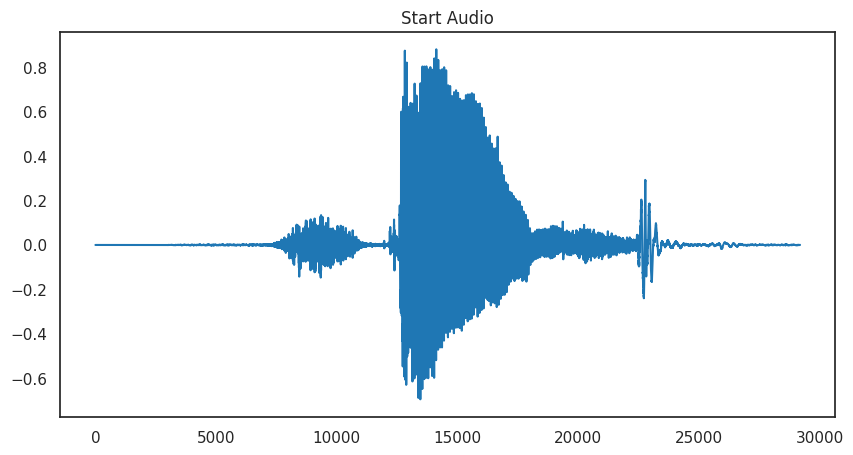

In [11]:
pd.Series(y).plot(figsize=(10, 5),
                  title='Start Audio',
                 color=color_pal[0])
plt.show()

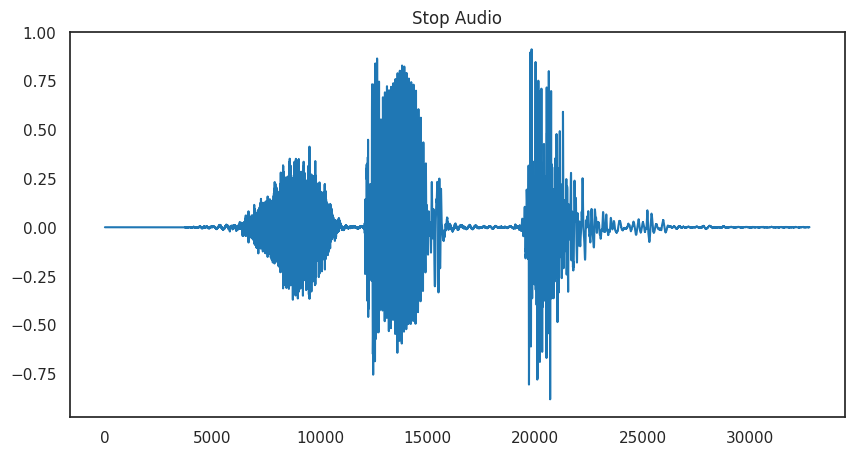

In [12]:
pd.Series(x).plot(figsize=(10, 5),
                  title='Stop Audio',
                 color=color_pal[0])
plt.show()

**Trim voice samples**

In [13]:
y_trimmed, _ = librosa.effects.trim(y, top_db= 45)
x_trimmed, _ = librosa.effects.trim(x, top_db= 45)

In [14]:
print(y_trimmed)


[0.00110891 0.00104936 0.00026714 ... 0.00162216 0.00161517 0.00181283]


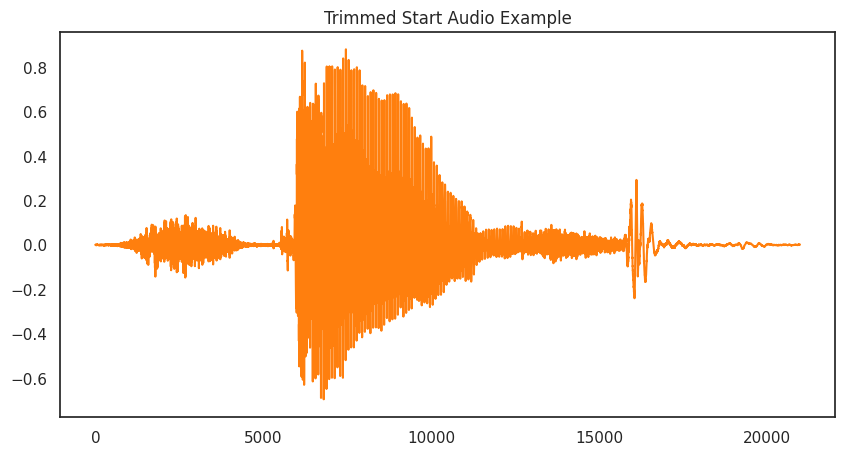

In [15]:
pd.Series(y_trimmed).plot(figsize=(10, 5),
                  title='Trimmed Start Audio Example',
                 color=color_pal[1])
plt.show()

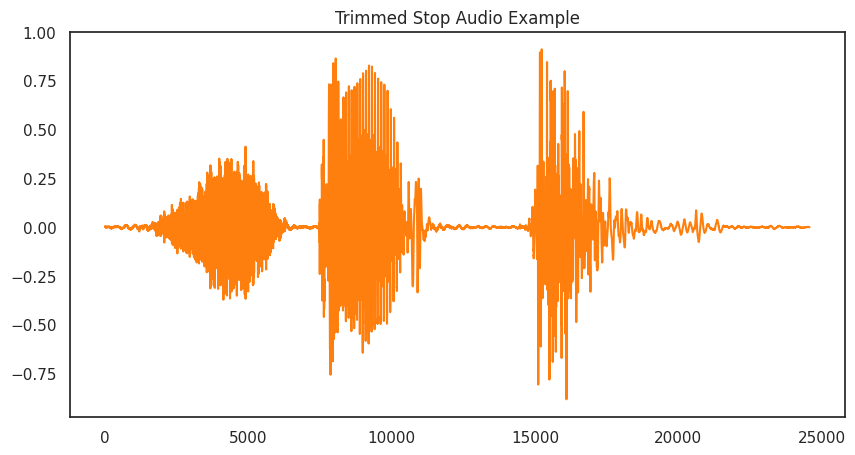

In [16]:
pd.Series(x_trimmed).plot(figsize=(10, 5),
                  title='Trimmed Stop Audio Example',
                 color=color_pal[1])
plt.show()

In [17]:
D = librosa.stft(y_trimmed)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
S_db.shape
B = librosa.stft(x_trimmed)
B_db = librosa.amplitude_to_db(np.abs(B), ref=np.max)
B_db.shape

(1025, 49)

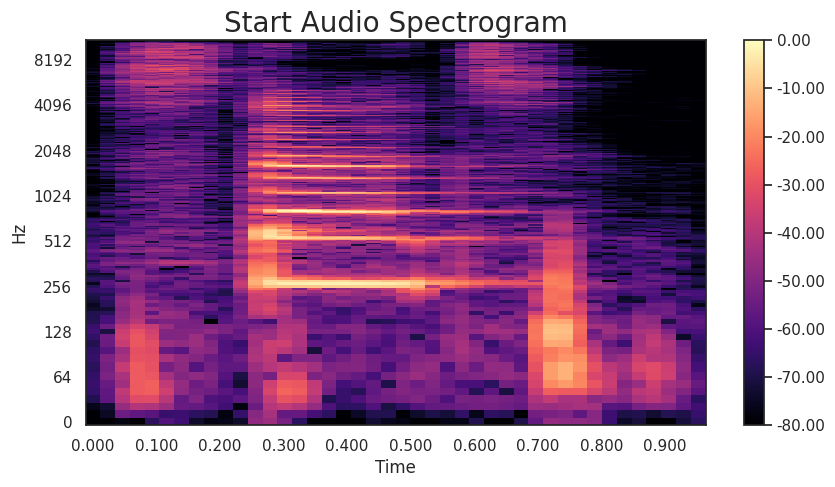

In [18]:
fig, ax = plt.subplots(figsize=(10, 5))
img = librosa.display.specshow(S_db,
                              x_axis='time',
                              y_axis='log',
                              ax=ax)
ax.set_title('Start Audio Spectrogram', fontsize=20)
fig.colorbar(img, ax=ax, format=f'%0.2f')
plt.show()

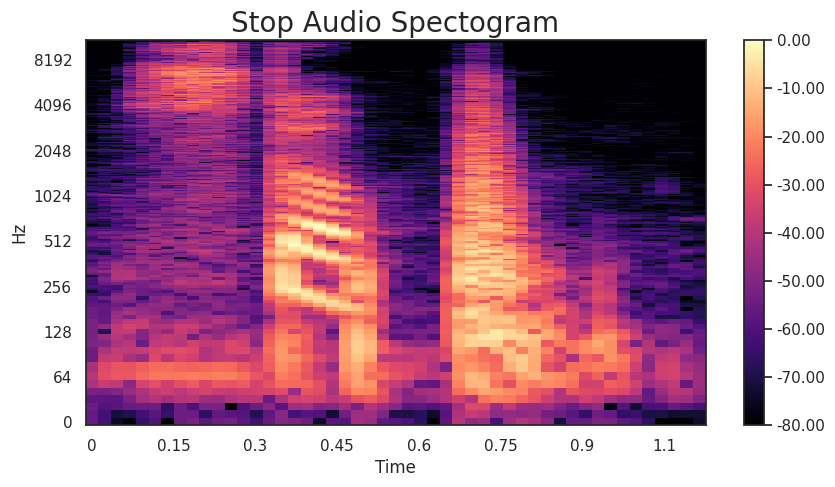

In [19]:
fig, ax = plt.subplots(figsize=(10, 5))
img = librosa.display.specshow(B_db,
                              x_axis='time',
                              y_axis='log',
                              ax=ax)
ax.set_title('Stop Audio Spectogram', fontsize=20)
fig.colorbar(img, ax=ax, format=f'%0.2f')
plt.show()

In [20]:
S = librosa.feature.melspectrogram(y=y,
                                   sr=sr,
                                   n_mels=128 * 2,)
S_db_mel = librosa.amplitude_to_db(S, ref=np.max)

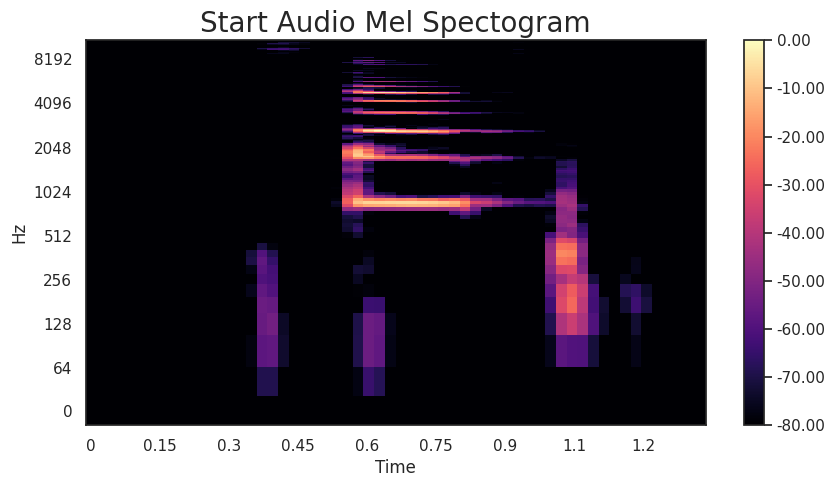

In [21]:
fig, ax = plt.subplots(figsize=(10, 5))
# Plot the mel spectogram
img = librosa.display.specshow(S_db_mel,
                              x_axis='time',
                              y_axis='log',
                              ax=ax)
ax.set_title('Start Audio Mel Spectogram', fontsize=20)
fig.colorbar(img, ax=ax, format=f'%0.2f')
plt.show()

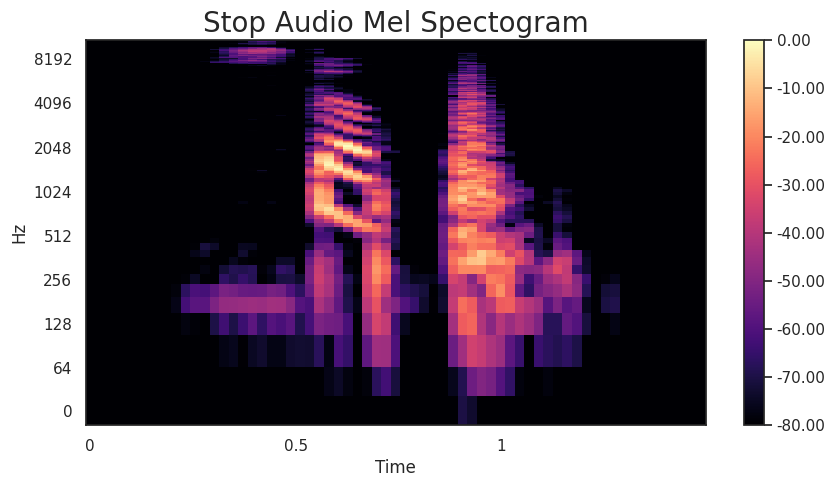

In [22]:
V = librosa.feature.melspectrogram(y=x,
                                   sr=sr,
                                   n_mels=128 * 2,)
V_db_mel = librosa.amplitude_to_db(V, ref=np.max)
fig, ax = plt.subplots(figsize=(10, 5))
# Plot the mel spectogram
img = librosa.display.specshow(V_db_mel,
                              x_axis='time',
                              y_axis='log',
                              ax=ax)
ax.set_title('Stop Audio Mel Spectogram', fontsize=20)
fig.colorbar(img, ax=ax, format=f'%0.2f')
plt.show()

In [23]:
V_db_mel.shape

(256, 65)

In [24]:
def mel_feq_extractor(file):
  y , sr = librosa.load(file)
  mfcc_features = librosa.feature.mfcc(y=y,
                                   sr=sr,
                                   n_mels=128 * 2,)
  mfcc_scaled = np.mean(mfcc_features.T, axis = 0)
  return mfcc_scaled

In [25]:
import numpy as np
from tqdm import tqdm
### Now we iterate through every audio file and extract features
### using Mel-Frequency Cepstral Coefficients
start_features=[]
for i in start_audio:
    data = mel_feq_extractor(i)
    start_features.append(data)

In [26]:
stop_features=[]
for i in stop_audio:
    data = mel_feq_extractor(i)
    stop_features.append(data)

In [27]:
start_df = pd.DataFrame(start_features)
start_pc = pd.DataFrame(start_features)
start_df['label'] = 1
print(start_df)
stop_df = pd.DataFrame(stop_features)
stop_pc = pd.DataFrame(stop_features)
stop_df['label'] = 0
print(stop_df)

             0           1          2          3          4          5  \
0  -507.299866   72.825287  25.028984  11.284401  -2.219630  13.254997   
1  -486.440613   76.810020  41.058746   6.106108  -5.499228  12.717114   
2  -447.856415   89.207176  34.040756   0.271980   1.707388  16.343653   
3  -418.072174   76.559853  32.729874  22.697784  -5.281943  16.597080   
4  -456.283722   86.681023  35.795277   2.781697  -0.786627  14.600329   
5  -527.709534   71.660004  39.128948  17.055813   0.150517   2.146160   
6  -413.399384   77.491318  32.654366  21.360298  -3.947476   4.635632   
7  -370.307800   59.569107  27.730906  28.491211  -3.648814   7.636062   
8  -460.628845   68.270912  32.214157  26.565165   3.357491   6.637870   
9  -428.379700   88.303421   8.776249  -3.921708 -18.574352  23.868900   
10 -475.738312   70.132614  11.434766 -13.384777 -14.617134   4.414014   
11 -512.243774   85.793221  35.441803   4.146666  -5.192966  14.626437   
12 -538.538696   59.841766  31.413292 

In [28]:
dataset = pd.concat([start_df, stop_df]).reset_index()
stop_pc['label'] = 0
start_pc['label'] = 1
pc_check = pd.concat([start_pc, stop_pc]).reset_index().drop(columns = 'index')
y = pc_check['label']
pc_check = pc_check.drop(columns = ['label'])

In [29]:
pc_check

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,-507.299866,72.825287,25.028984,11.284401,-2.219630,13.254997,-14.936328,-13.913272,4.732986,4.863887,-1.277915,-2.056002,-1.413733,2.236975,2.939550,-3.536933,-5.392798,7.067389,-8.055802,-0.085411
1,-486.440613,76.810020,41.058746,6.106108,-5.499228,12.717114,-15.256100,-2.794284,-0.827501,5.752750,-7.665136,-7.146224,0.382389,-0.208093,5.148291,-7.241117,-3.048070,2.660868,-4.741507,3.824581
2,-447.856415,89.207176,34.040756,0.271980,1.707388,16.343653,-21.897137,2.630259,-3.378421,8.879468,-3.525001,-3.652403,-2.692193,0.314052,5.382502,-6.606222,1.143038,0.290347,-6.237832,3.671489
3,-418.072174,76.559853,32.729874,22.697784,-5.281943,16.597080,-5.412432,-1.458758,-5.388261,1.064988,-9.990322,-7.990450,-3.018026,-3.130176,5.949511,-7.458376,4.436962,-0.650500,-9.318608,5.456701
4,-456.283722,86.681023,35.795277,2.781697,-0.786627,14.600329,-4.338963,-0.255498,-2.343214,4.981025,-0.360869,-8.186772,-2.413084,2.254503,3.758421,-7.621869,-9.062757,-1.249330,-9.804224,7.261540
5,-527.709534,71.660004,39.128948,17.055813,0.150517,2.146160,-10.845922,3.418629,-5.018034,-1.338595,-1.395725,-3.971530,-1.602174,-4.559658,1.740628,-5.200023,-3.092682,3.451838,-0.646835,4.684369
6,-413.399384,77.491318,32.654366,21.360298,-3.947476,4.635632,-6.859564,-8.212808,-6.029121,-7.996558,-2.226762,-9.051183,-11.216280,-4.223247,2.783870,-7.889617,-3.432807,1.112346,-1.135130,9.007421
7,-370.307800,59.569107,27.730906,28.491211,-3.648814,7.636062,-9.073400,3.010641,-16.192787,-5.569222,-12.356441,-8.364966,-9.588302,-8.075341,10.375945,-3.046124,16.339495,5.235462,-2.045178,7.971043
8,-460.628845,68.270912,32.214157,26.565165,3.357491,6.637870,-4.037296,-0.412729,-4.804451,-6.763765,2.128797,-7.005620,-3.759442,-2.240184,1.631305,-4.940300,-2.482591,3.607191,-1.583297,7.735044
9,-428.379700,88.303421,8.776249,-3.921708,-18.574352,23.868900,-10.637067,-9.673687,-0.856166,5.577230,-1.816878,-17.353790,-7.588120,5.992036,-5.957619,-6.938611,-5.784202,1.195471,1.967195,6.900524


## 2. Dimension Analysis

In [30]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
pc = pca.fit_transform(pc_check)
pc = pd.DataFrame(pc)
print(pc)

             0          1          2          3          4
0    33.271236 -28.289789  -0.834997  -6.315278 -10.373581
1    13.960482 -20.329489  -0.247099  -9.648588   9.192116
2   -20.550369  -5.550174  15.070416 -16.715248  11.670616
3   -54.414371  -2.067677  -2.520636  -6.678019   0.760653
4   -12.375528  -5.786578   9.021594 -17.913830   6.361728
5    51.264217 -29.191092 -19.641628  -0.168885   7.501688
6   -59.387623  -3.415456  -0.637016  -0.618015   2.075778
7  -106.878197  -9.913315  -7.226149   3.949757   6.896132
8   -15.378875 -16.732122 -17.408276  -3.558479  -2.818326
9   -39.463787  -5.644227  38.115124  -4.902613  -7.110683
10    2.423271 -37.507298  28.867315   7.196013   0.614612
11   42.056221 -15.738328  -0.308783 -11.225085   5.766550
12   61.244808 -44.102867 -10.253260   0.127225  -3.278209
13   38.997425 -26.050932  13.689343   6.485007  -0.671818
14  -39.846519  22.209742   9.754731  -4.843974   2.750707
15   37.617397  17.013086 -10.083789   3.359462  -5.3874

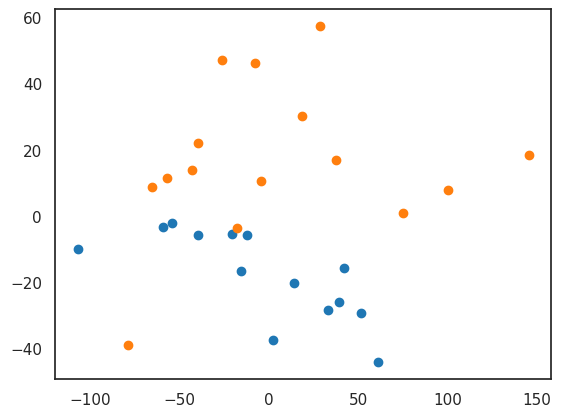

In [31]:
for frame in [pc[0:14], pc[14:29]]:
  plt.scatter(frame[0], frame[1])

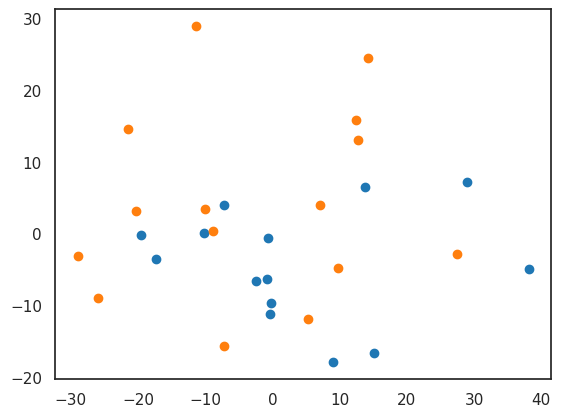

In [32]:
for frame in [pc[0:14], pc[14:29]]:
  plt.scatter(frame[2], frame[3])

In [33]:
print(pc)

             0          1          2          3          4
0    33.271236 -28.289789  -0.834997  -6.315278 -10.373581
1    13.960482 -20.329489  -0.247099  -9.648588   9.192116
2   -20.550369  -5.550174  15.070416 -16.715248  11.670616
3   -54.414371  -2.067677  -2.520636  -6.678019   0.760653
4   -12.375528  -5.786578   9.021594 -17.913830   6.361728
5    51.264217 -29.191092 -19.641628  -0.168885   7.501688
6   -59.387623  -3.415456  -0.637016  -0.618015   2.075778
7  -106.878197  -9.913315  -7.226149   3.949757   6.896132
8   -15.378875 -16.732122 -17.408276  -3.558479  -2.818326
9   -39.463787  -5.644227  38.115124  -4.902613  -7.110683
10    2.423271 -37.507298  28.867315   7.196013   0.614612
11   42.056221 -15.738328  -0.308783 -11.225085   5.766550
12   61.244808 -44.102867 -10.253260   0.127225  -3.278209
13   38.997425 -26.050932  13.689343   6.485007  -0.671818
14  -39.846519  22.209742   9.754731  -4.843974   2.750707
15   37.617397  17.013086 -10.083789   3.359462  -5.3874

In [34]:
X = pc

In [35]:
print(X)

             0          1          2          3          4
0    33.271236 -28.289789  -0.834997  -6.315278 -10.373581
1    13.960482 -20.329489  -0.247099  -9.648588   9.192116
2   -20.550369  -5.550174  15.070416 -16.715248  11.670616
3   -54.414371  -2.067677  -2.520636  -6.678019   0.760653
4   -12.375528  -5.786578   9.021594 -17.913830   6.361728
5    51.264217 -29.191092 -19.641628  -0.168885   7.501688
6   -59.387623  -3.415456  -0.637016  -0.618015   2.075778
7  -106.878197  -9.913315  -7.226149   3.949757   6.896132
8   -15.378875 -16.732122 -17.408276  -3.558479  -2.818326
9   -39.463787  -5.644227  38.115124  -4.902613  -7.110683
10    2.423271 -37.507298  28.867315   7.196013   0.614612
11   42.056221 -15.738328  -0.308783 -11.225085   5.766550
12   61.244808 -44.102867 -10.253260   0.127225  -3.278209
13   38.997425 -26.050932  13.689343   6.485007  -0.671818
14  -39.846519  22.209742   9.754731  -4.843974   2.750707
15   37.617397  17.013086 -10.083789   3.359462  -5.3874

In [36]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.45, stratify = y , random_state=1)

In [37]:
y

0     1
1     1
2     1
3     1
4     1
5     1
6     1
7     1
8     1
9     1
10    1
11    1
12    1
13    1
14    1
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
Name: label, dtype: int64

In [38]:
X_train

,0,1,2,3,4
6,-59.387623,-3.415456,-0.637016,-0.618015,2.075778
3,-54.414371,-2.067677,-2.520636,-6.678019,0.760653
21,-7.566499,46.374233,27.406042,-2.924478,1.010547
25,100.139442,7.813044,12.359720,15.807420,-9.008706
17,-56.951382,11.555301,-20.305349,3.069924,-21.541916
19,-17.587101,-3.619927,-28.988251,-3.079701,-16.077997
1,13.960482,-20.329489,-0.247099,-9.648588,9.192116
0,33.271236,-28.289789,-0.834997,-6.315278,-10.373581
9,-39.463787,-5.644227,38.115124,-4.902613,-7.110683
18,-43.214516,14.059359,-26.007416,-9.012712,-5.676619


## 3. Model Building and Evaluation

In [39]:
from sklearn.svm import SVC
clf = SVC(C=10,kernel='rbf')

In [40]:
# Hyper Parameter Tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
C= [ 1,10,15,20,25,30,100,1000]
kernel = ['rbf', 'linear']
param_grid = dict(C = C,kernel = kernel)
searcher = GridSearchCV(clf, n_jobs=-1, cv=5,
	param_grid=param_grid, scoring="accuracy")
searchResults = searcher.fit(X_train, y_train)

In [41]:
print(searchResults.best_score_)
print(searchResults.best_params_)

0.9333333333333333
{'C': 1, 'kernel': 'linear'}


In [42]:
model = searcher.best_estimator_

In [43]:
y_pred = model.predict(X_test)

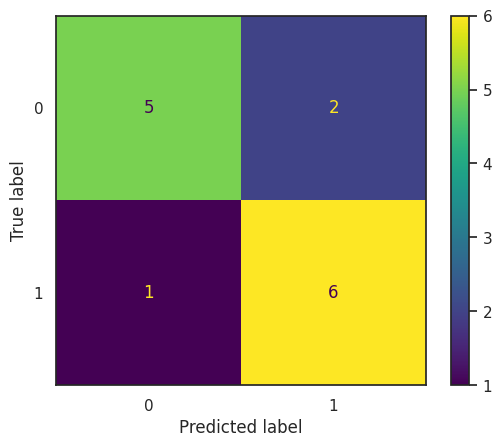

In [44]:
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)

In [45]:
score = f1_score(y_test, y_pred)
print(f"F1 Score is: {score}")

F1 Score is: 0.7999999999999999
